In [1]:
from bs4 import BeautifulSoup
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
for dirname, _, filenames in os.walk('/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# face bnb boxes from annotation file
def get_bnb_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]


# convert labels from annotation file to numbers
def get_label(obj):
    if obj.find('name').text == 'without_mask':
        return 0
    elif obj.find('name').text == 'mask_weared_incorrect':
        return 2
    else:
        return 1


def get_objects(img_id, file):
    print(file)
    with open(file, 'r') as f:
        data = f.read()
        soup_parser = BeautifulSoup(data, 'xml')
        objs = soup_parser.find_all('object')

        nums_of_objs = len(objs)

        bnb_boxes = []
        labels = []
        for i in objs:
            bnb_boxes.append(get_bnb_box(i))
            labels.append(get_label(i))

        bnb_boxes = np.array(bnb_boxes)
        labels = np.array(labels)
        img_id = np.array(img_id)

        result = {}
        result["boxes"] = bnb_boxes
        result["labels"] = labels

        return (result, nums_of_objs)


In [4]:
images = list(sorted(os.listdir('dataset/images')))
labels = list(sorted(os.listdir('dataset/annotations')))

In [9]:
objs = []
nums_of_objs = []
DIRNAME = os.path.dirname(os.path.abspath("__file__"))

for i in range(len(images)):
    label_file = 'maksssksksss' + str(i) + '.xml'
    label_path = os.path.join(DIRNAME + "/dataset/annotations/", label_file)
    print(get_objects(i, label_path))
    obj, num_of_obj = get_objects(i, label_path)
    objs.append(obj)
    nums_of_objs.append(num_of_obj)

/Users/lubica.dubravcova/PycharmProjects/diplm/training/dataset/annotations/maksssksksss0.xml
({'boxes': array([[ 79, 105, 109, 142],
       [185, 100, 226, 144],
       [325,  90, 360, 141]]), 'labels': array([0, 1, 0])}, 3)
/Users/lubica.dubravcova/PycharmProjects/diplm/training/dataset/annotations/maksssksksss0.xml
/Users/lubica.dubravcova/PycharmProjects/diplm/training/dataset/annotations/maksssksksss1.xml
({'boxes': array([[321,  34, 354,  69],
       [224,  38, 261,  73],
       [299,  58, 315,  81],
       [143,  74, 174, 115],
       [ 74,  69,  95,  99],
       [191,  67, 221,  93],
       [ 21,  73,  44,  93],
       [369,  70, 398,  99],
       [ 83,  56, 111,  89]]), 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 0])}, 9)
/Users/lubica.dubravcova/PycharmProjects/diplm/training/dataset/annotations/maksssksksss1.xml
/Users/lubica.dubravcova/PycharmProjects/diplm/training/dataset/annotations/maksssksksss2.xml
({'boxes': array([[ 68,  42, 105,  69],
       [154,  47, 178,  74],
     

In [24]:
face_imgs = []
face_labels = []

for i in range(len(images)):
    image_file = 'maksssksksss' + str(i) + '.png'
    img_path = os.path.join(DIRNAME + "/dataset/images/", image_file)
    image = cv2.imread(img_path)
    for j in range(nums_of_objs[i]):
        bnb = (objs[i]["boxes"][j])
        image1 = image[bnb[1]:bnb[3], bnb[0]:bnb[2]]
        image1 = cv2.resize(image1, (224, 224))
        image1 = img_to_array(image1)
        image1 = preprocess_input(image1)
        face_imgs.append(image1)
        face_labels.append(objs[i]["labels"][j])

face_imgs = np.array(face_imgs, dtype="float32")
face_labels = np.array(face_labels)

In [7]:
len(face_labels)

4072

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


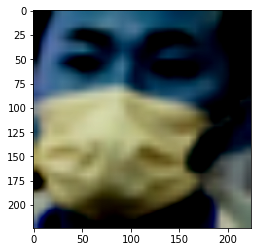

1


In [25]:
from matplotlib import pyplot as plt
plt.imshow(face_imgs[3])
plt.show()
print(face_labels[3])

In [26]:
keys, counts = np.unique(face_labels, return_counts=True)
dict(zip(keys, counts))

{0: 717, 1: 3232, 2: 123}

In [27]:
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(face_labels)
labels = to_categorical(labels)

In [28]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [60]:
# Data preprocessing - augmentation
# Our model would never see twice the exact same picture.
# This helps prevent overfitting and helps the model generalize better.

aug = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [61]:
# pre-training on ImageNet
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False


In [62]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [63]:
(trainX, testX, trainY, testY) = train_test_split(face_imgs, labels, test_size=0.25, stratify=labels, random_state=42)

In [64]:
del objs, face_imgs, face_labels

In [65]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    class_weight={0: 5, 1: 1, 2: 10}
)

Epoch 1/20
95/95 [==============================] - 102s 1s/step - loss: 1.6358 - accuracy: 0.7035 - val_loss: 0.5982 - val_accuracy: 0.7377
Epoch 2/20
95/95 [==============================] - 103s 1s/step - loss: 1.2843 - accuracy: 0.7872 - val_loss: 0.4605 - val_accuracy: 0.8222
Epoch 3/20
95/95 [==============================] - 101s 1s/step - loss: 1.1742 - accuracy: 0.8071 - val_loss: 0.5755 - val_accuracy: 0.7662
Epoch 4/20
95/95 [==============================] - 106s 1s/step - loss: 1.0729 - accuracy: 0.8200 - val_loss: 0.4122 - val_accuracy: 0.8379
Epoch 5/20
95/95 [==============================] - 102s 1s/step - loss: 1.0270 - accuracy: 0.8259 - val_loss: 0.3766 - val_accuracy: 0.8546
Epoch 6/20
95/95 [==============================] - 98s 1s/step - loss: 0.9941 - accuracy: 0.8385 - val_loss: 0.4524 - val_accuracy: 0.8193
Epoch 7/20
95/95 [==============================] - 102s 1s/step - loss: 0.9517 - accuracy: 0.8438 - val_loss: 0.3461 - val_accuracy: 0.8654
Epoch 8/20
95/

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.60      0.96      0.73       179
           1       0.98      0.80      0.88       808
           2       0.26      0.58      0.36        31

    accuracy                           0.82      1018
   macro avg       0.61      0.78      0.66      1018
weighted avg       0.89      0.82      0.84      1018



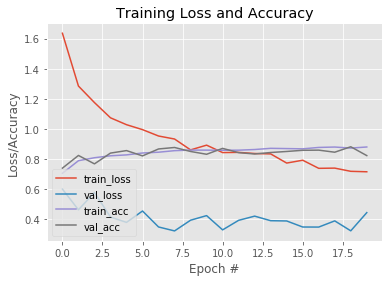

In [67]:
print('[INFO] evaluating network...')
predIdxs = model.predict(testX, batch_size=32)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [68]:
model.save('../model/kaggle_third.h5')